# Boruta and PPScore

# setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
from plotnine.data import diamonds

In [4]:
data = diamonds
data = data.sample(1000)

In [5]:
clf = RandomForestRegressor(n_jobs = -1, max_depth = 5)

In [6]:
X = data.drop(columns=['price'])
X = pd.get_dummies(X,columns=['cut','color','clarity'])
y = data.price

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# random forest

In [8]:
clf = RandomForestRegressor(n_estimators=40, 
                            min_samples_leaf=3, 
                            max_features=0.5, 
                            n_jobs=-1, 
                            oob_score=True)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# metrics 

In [9]:
clf.score(X_train, y_train)

0.9656380528991501

In [10]:
clf.score(X_test, y_test)

0.9415559580344527

In [11]:
clf.oob_score_

0.9020304870519256

In [ ]:
# feature importance 

In [12]:
df_importances = pd.DataFrame( {'feature_names' : X_train.columns,
                                'feature_importance' : clf.feature_importances_})
df_importances.sort_values('feature_importance', inplace=True)

In [13]:
df_importances.sort_values('feature_importance', ascending=False)

,feature_names,feature_importance
0,carat,0.306448
4,y,0.278959
3,x,0.175385
5,z,0.164541
19,clarity_SI2,0.013121
23,clarity_VVS2,0.011667
14,color_G,0.006747
1,depth,0.006171
11,color_D,0.004496
20,clarity_SI1,0.004428


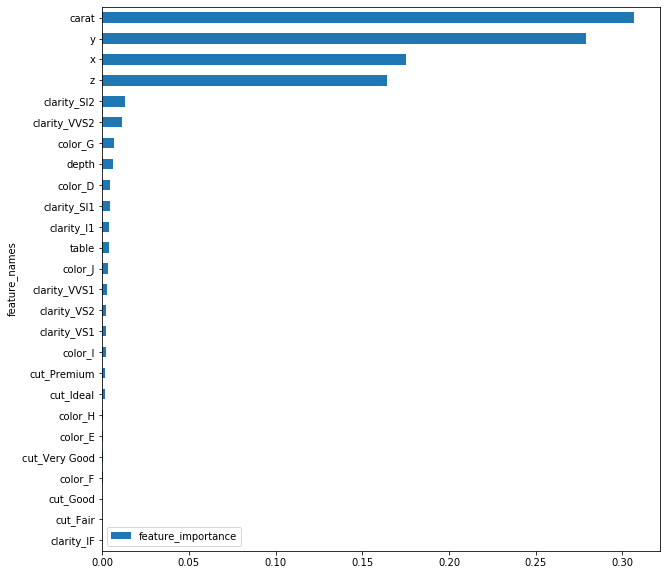

In [14]:
df_importances.plot(kind='barh', 
                    x= 'feature_names', 
                    y='feature_importance',
                    figsize=[10,10])

# boruta feature selection

In [15]:
from boruta import BorutaPy

In [16]:
boruta_selector = BorutaPy(clf, 
                           n_estimators = 'auto', 
                           random_state = 0)

In [17]:
boruta_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=None,
                                         max_features=0.5, max_leaf_nodes=None,
                                         max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=3,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=37, n_jobs=-1,
                                         oob_score=True,
                                         random_state=RandomState(MT19937) at 0x1A1F20D490,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_state=R

In [18]:
df_boruta_rankings= pd.DataFrame( {'feature_names' : X_train.columns,
                                   'feature_rank' : boruta_selector.ranking_})
df_boruta_rankings.sort_values('feature_rank', inplace=True)

In [19]:
df_boruta_rankings

,feature_names,feature_rank
0,carat,1
3,x,1
4,y,1
5,z,1
23,clarity_VVS2,1
19,clarity_SI2,1
14,color_G,2
1,depth,3
18,clarity_I1,4
20,clarity_SI1,4


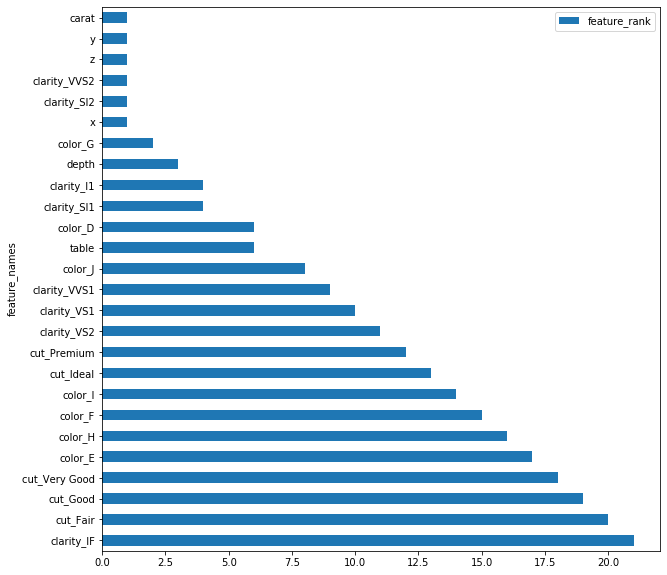

In [20]:
df_boruta_rankings = df_boruta_rankings.sort_values('feature_rank',
                                                    ascending=False)
df_boruta_rankings.plot(kind='barh', 
                    x= 'feature_names', 
                    y='feature_rank',
                    figsize=[10,10])

In [21]:
selected_features = np.array(X_train.columns)[boruta_selector.ranking_ <= 2]
list(selected_features)

['carat', 'x', 'y', 'z', 'color_G', 'clarity_SI2', 'clarity_VVS2']

# predictive power score

In [22]:
import ppscore as pps

In [23]:
pps.score(data, "carat", "price")

{'x': 'carat',
 'y': 'price',
 'task': 'regression',
 'ppscore': 0.672148062528783,
 'metric': 'mean absolute error',
 'baseline_score': 2899.154,
 'model_score': 950.4932559274284,
 'model': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')}

In [24]:
pp_matrix = pps.matrix(data)

In [25]:
pp_matrix

,carat,cut,color,clarity,depth,table,price,x,y,z
carat,1.000000,0,0,0,0.000000,0.000000,0.683925,0.927892,0.932316,0.924303
cut,0.144719,1,0,0,0.373590,0.353869,0.069545,0.112666,0.146819,0.149218
color,0.158320,0,1,0,0.101733,0.058846,0.108801,0.102018,0.100725,0.092199
clarity,0.105238,0,0,1,0.091723,0.111628,0.150797,0.108224,0.106764,0.144774
depth,0.000000,0,0,0,1.000000,0.030556,0.000000,0.000000,0.000000,0.000000
table,0.000000,0,0,0,0.040889,1.000000,0.000000,0.000000,0.000000,0.000000
price,0.672148,0,0,0,0.000000,0.000000,1.000000,0.638237,0.618047,0.635593
x,0.939780,0,0,0,0.000000,0.009008,0.692205,1.000000,0.943791,0.879291
y,0.938703,0,0,0,0.000000,0.009633,0.694169,0.941720,1.000000,0.879181
z,0.930685,0,0,0,0.000000,0.003327,0.690687,0.871815,0.878063,1.000000


In [26]:
pp_matrix[pp_matrix.index == 'price']

,carat,cut,color,clarity,depth,table,price,x,y,z
price,0.672148,0,0,0,0.0,0.0,1.0,0.638237,0.618047,0.635593


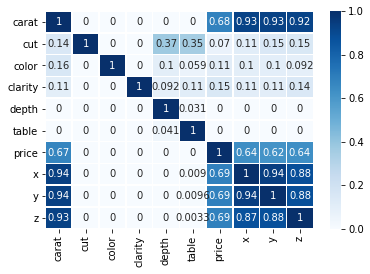

In [27]:
df_matrix = pps.matrix(data)
sns.heatmap(df_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)